In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc3 as pm
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from theano import shared
import theano.tensor as T
from pymc3 import *
import warnings
warnings.filterwarnings('ignore')

In [48]:
#Importing dataset
df = pd.read_csv('breast-cancer-wisconsin.csv')
df.drop(['id'],1,inplace=True)

# Convert '?' to NaN
df[df == '?'] = np.nan
# Drop missing values and print shape of new DataFrame
df = df.dropna()

X = scale(np.array(df.drop(['class'],1)))
y = np.array(df['class'])/2-1

#Split Data
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2, random_state=42)

#Sharedvariable
model_input = shared(X_tr)
model_output= shared(y_tr)

In [46]:
#Generate Model
logistic_model = pm.Model()
with logistic_model:
    # Priors for unknown model parameters    
    alpha = pm.Normal("alpha", mu=0,sd=1)
    betas = pm.Normal("betas", mu=0, sd=1, shape=X.shape[1])
    
    # Expected value of outcome
    p = pm.invlogit(alpha + T.dot(model_input,betas))
    

    # Likelihood (sampling distribution of observations)
    y = pm.Bernoulli('y', p, observed=model_output)

In [106]:
#infering parameters
with logistic_model:
    advi=pm.ADVI()
    approx = advi.fit(n=10000,more_replacements={
        model_input:pm.Minibatch(X_tr),
        model_output:pm.Minibatch(y_tr)
    
     }
        )

Average Loss = 56.98: 100%|██████████████████████████████████████████████████████| 10000/10000 [19:51<00:00,  8.40it/s]
Finished [100%]: Average Loss = 56.93


In [107]:
#Replace shared variable with testing set
model_input.set_value(X_te)
model_output.set_value(y_te)

# Creater posterior predictive samples
trace = approx.sample(draws=10000)
ppc = pm.sample_ppc(trace,model=logistic_model,samples=1000)
pred = ppc['y'].mean(axis=0) > 0.5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.03it/s]


              mean        sd  mc_error   hpd_2.5  hpd_97.5
alpha    -1.145930  0.330157  0.002603 -1.799608 -0.507814
betas__0  1.167867  0.386099  0.004000  0.414481  1.912560
betas__1  0.534784  0.463733  0.004811 -0.340407  1.484352
betas__2  0.807416  0.438676  0.004373 -0.056159  1.681417
betas__3  0.813409  0.386622  0.003277  0.065678  1.566850
betas__4  0.186660  0.373106  0.003899 -0.572600  0.876937
betas__5  1.285633  0.380215  0.003886  0.520754  2.000204
betas__6  1.093530  0.465338  0.004913  0.195468  1.996610
betas__7  0.585016  0.367867  0.003726 -0.117070  1.320395
betas__8  0.777436  0.487690  0.004694 -0.149465  1.728349


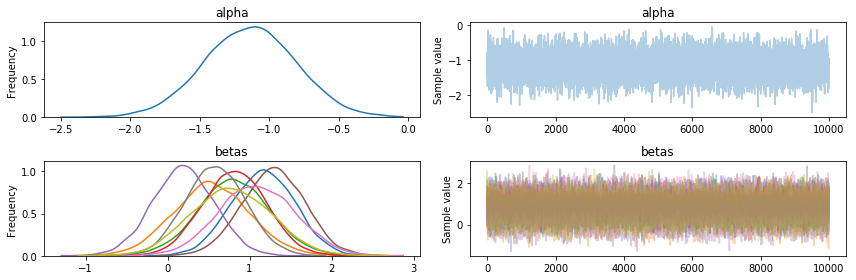

In [109]:
print(pm.summary(trace))
pm.plots.traceplot(trace)
plt.show()

In [110]:
print(y_tr.shape)
print(X_te.shape)
print(y_te.shape)
print(pred.shape)

print('Accuracy = {}%'.format((y_te == pred).mean() * 100))

(546,)
(137, 9)
(137,)
(546,)


AttributeError: 'bool' object has no attribute 'mean'